In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [40]:
data = pd.read_pickle('../data/data_full.pkl')

data['DATETIME'] = data.index
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data = data.asfreq('30T')

data['year'] = data['DATETIME'].dt.year
data['month'] = data['DATETIME'].dt.month
data['day'] = data['DATETIME'].dt.day
data['hour'] = data['DATETIME'].dt.hour
data['min'] = data['DATETIME'].dt.minute
data = data.drop(['DATETIME'], axis=1)

In [41]:
data_train = data.loc[data.index < '2023-10-30']
data_test = data.loc[data.index >= '2023-10-30']

In [42]:
X_train = data_train.drop('demand', axis=1)
X_test = data_test.drop('demand', axis=1)

y_train = data_train['demand']
y_train.name = 'Actual demand (train)'
y_test = data_test['demand']
y_test.name = 'Actual demand (test)'

# Model Implementation

In [43]:
import xgboost as xgb

In [44]:
tscv = TimeSeriesSplit(n_splits=6)

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, 
                                   n_iter=100, cv=tscv, verbose=2, n_jobs=-1, 
                                   scoring='neg_mean_squared_error')

In [45]:
random_search.fit(X_train, y_train)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=No...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 400],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_squared_error', verbose=2)

## Prediction

In [46]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

## Prediction Statistics

In [47]:
y_pred_s = pd.Series(y_pred, index=y_test.index, name='Predicted demand (test)')

### 24 Hours Forecast

In [48]:
y_pred_48 = y_pred_s.iloc[:48]
y_test_48 = y_test.iloc[:48]

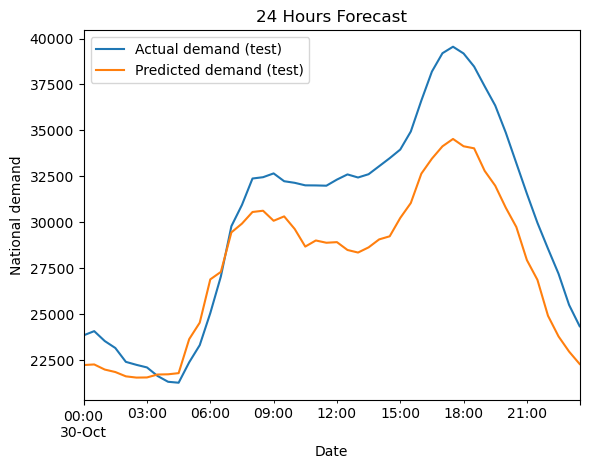

In [49]:
fig, ax = plt.subplots()
y_test_48.plot(ax=ax)
y_pred_48.plot(ax=ax)
ax.legend()
ax.set_title('24 Hours Forecast')
ax.set_xlabel("Date")
ax.set_ylabel("National demand")
plt.show()

In [50]:
print(f'RMSE for 24 hours: {mean_squared_error(y_test_48, y_pred_48, squared=False)}')

RMSE for 24 hours: 3092.5987422469902


### 7 Days Prediction

In [51]:
y_pred_336 = y_pred_s.iloc[:336]
y_test_336 = y_test.iloc[:336]

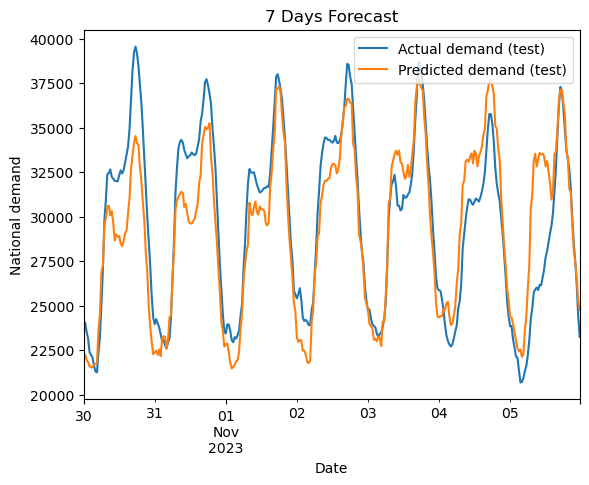

In [52]:
fig, ax = plt.subplots()
y_test_336.plot(ax=ax)
y_pred_336.plot(ax=ax)
ax.legend()
ax.set_title('7 Days Forecast')
ax.set_xlabel("Date")
ax.set_ylabel("National demand")
plt.show()

In [53]:
print(f'RMSE for 7 days: {mean_squared_error(y_test_336, y_pred_336, squared=False)}')

RMSE for 7 days: 2378.7031510845027


### 28 Days Prediction

In [54]:
y_pred_1344 = y_pred_s.iloc[:1344]
y_test_1344 = y_test.iloc[:1344]

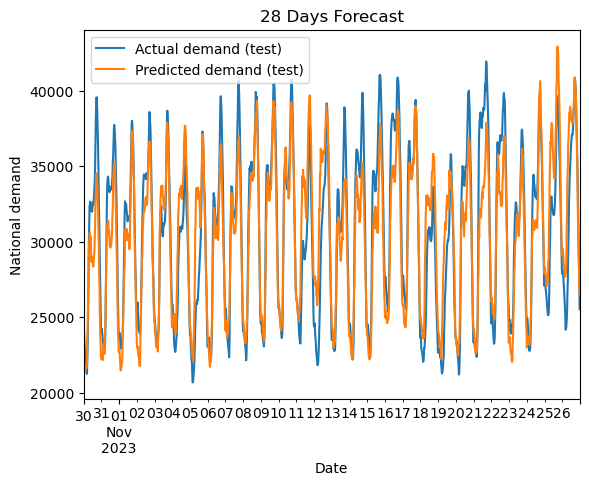

In [55]:
fig, ax = plt.subplots()
y_test_1344.plot(ax=ax)
y_pred_1344.plot(ax=ax)
ax.legend()
ax.set_title('28 Days Forecast')
ax.set_xlabel("Date")
ax.set_ylabel("National demand")
plt.show()

In [56]:
print(f'RMSE for 28 days: {mean_squared_error(y_test_1344, y_pred_1344, squared=False)}')

RMSE for 28 days: 2432.037289343679
